In [294]:
# [10:12 PM]

usingSavedModel = False

from datetime import *

# IMPORTANT note to self: this is the best working version so far.
# the other somewhat working but screwed up version is called 
# v1REALTP_lstm_stuff

# Author: Roshan Ram
# AndrewID: rram

import yfinance as yfinance

# import module_manager
# module_manager.review()

import yfinance as yf # to pull stock data with yf.download(name, yyyy-mm-dd of opening, yyyy-mm-dd of opening)

import numpy as np # used for everything lol
import pandas as pd # data mainpulation
import matplotlib.pyplot as plt # graphing/plotting
from keras import *

import time, random, copy

#####
import numpy as np
import os
import sys
import time
import pandas as pd 
# from tqdm._tqdm_notebook import tqdm_notebook
import pickle
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout
from keras.layers import LSTM
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, CSVLogger
from keras import optimizers
# from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import logging
####

# %matplotlib inline 
#just to make stuff look nice

In [295]:
TIME_STEPS = 60
batchSize = 20
min_max_scaler = MinMaxScaler()

In [296]:
stock = None
while not isinstance(stock, str):
    stock = input("Enter your desired stock. Only alphanumeric characters please.")
openingInp = input("Enter your desired opening date. (yyyy-mm-dd)") #'2016-01-01'
closingInp = input("Enter your desired closing date. (yyyy-mm-dd)") # '2019-08-01'


data = yf.download(stock, openingInp, closingInp)


def getData_LSTM(app):
    stock = None
#     while not isinstance(stock, str):
    stock = app.getUserInput("Enter your desired stock. Only alphanumeric characters please.")
    openingInp = app.getUserInput("Enter your desired opening date. (yyyy-mm-dd)") #'2016-01-01'
    closingInp = app.getUserInput("Enter your desired closing date. (yyyy-mm-dd)") # '2019-08-01'


    data = yf.download(stock, openingInp, closingInp)
    return data, stock 

# data, stock = getData(app)

Enter your desired stock. Only alphanumeric characters please.AAPL
Enter your desired opening date. (yyyy-mm-dd)2016-08-01
Enter your desired closing date. (yyyy-mm-dd)2019-01-01
[*********************100%***********************]  1 of 1 completed


In [297]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

def mainFunc1(data):

#     TIME_STEPS = 10 # [rram]
#     batchSize = 32 # [rram]


#     #####
#     params = {
#         "batch_size": 20,  # 20<16<10, 25 was a bust
#         "epochs": 300,
#         "lr": 0.00010000,
#         "time_steps": 60
#     }

#     iter_changes = "dropout_layers_0.4_0.4"

#     # INPUT_PATH = PATH_TO_DRIVE_ML_DATA+"/inputs"
#     OUTPUT_PATH = '~/Desktop'
#     TIME_STEPS = params["time_steps"]
#     batchSize = params["batch_size"]
#     stime = time.time()
#     ###


    train_cols = ["Open","High","Low","Close","Volume"]
    df_train, df_test = train_test_split(data, train_size=0.8, test_size=0.2, shuffle=False)
    print("Train and Test size", len(df_train), len(df_test))
    # scale the feature MinMax, build array
    x = df_train.loc[:,train_cols].values
    x_train = min_max_scaler.fit_transform(x)
    x_test = min_max_scaler.transform(df_test.loc[:,train_cols])
    
#     print((x_train.shape))
#     print((x_test.shape))
    
    return x_train, x_test

In [298]:
x_train, x_test = mainFunc1(data)  # IMP!

Train and Test size 487 122


In [299]:
def createTimesteps(mat, y_col_index):
    # y_col_index is the index of column that would act as output column
    # total number of time-series samples would be len(mat) - TIME_STEPS
    dim_0 = mat.shape[0] - TIME_STEPS
    dim_1 = mat.shape[1]
    x = np.zeros((dim_0, TIME_STEPS, dim_1))
    y = np.zeros((dim_0,))

    for i in (range(dim_0)):
        x[i] = mat[i:TIME_STEPS+i]
        y[i] = mat[TIME_STEPS+i, y_col_index]
    print("length of time-series i/o",x.shape,y.shape)
    return x, y

def createDataset(mat, batch_size):
    """
    trims dataset to a size that's divisible by batchSize
    """
    no_of_rows_drop = mat.shape[0]%batch_size
    if(no_of_rows_drop > 0):
        return mat[:-no_of_rows_drop]
    else:
        return mat


In [300]:
def mainFunc2(x_test, x_train):
    x_t, y_t = createTimesteps(x_train, 3)
    x_t = createDataset(x_t, batchSize)
    y_t = createDataset(y_t, batchSize)
    x_temp, y_temp = createTimesteps(x_test, 3)
    x_val, x_test_t = np.split(createDataset(x_temp, batchSize),2)
    y_val, y_test_t = np.split(createDataset(y_temp, batchSize),2)
    return x_t, y_t, x_val, x_test_t, y_val, y_test_t

In [301]:
x_t, y_t, x_val, x_test_t, y_val, y_test_t = mainFunc2(x_test, x_train)  # IMP!

length of time-series i/o (427, 60, 5) (427,)
length of time-series i/o (62, 60, 5) (62,)


In [302]:
# this function creates a model with MSE as an accuracy-measuring metric

def create_model(x_t):
    lstm_model = Sequential()
    lstm_model.add(LSTM(100, batch_input_shape=(batchSize, TIME_STEPS, x_t.shape[2]), dropout=0.0, recurrent_dropout=0.0, stateful=True,     kernel_initializer='random_uniform'))
    lstm_model.add(Dropout(0.5))
    lstm_model.add(Dense(20,activation='relu'))
    lstm_model.add(Dense(1,activation='sigmoid'))
    optimizer = optimizers.RMSprop(lr=0.00010000)
    lstm_model.compile(loss='mean_squared_error', optimizer=optimizer)
    model = lstm_model
    return model

In [303]:
if not usingSavedModel:
    model = create_model(x_t)  # IMP!
    
    today = date.today()
    d4 = today.strftime("%b-%d-%Y")
    # ^Credit: https://www.programiz.com/python-programming/datetime/current-datetime

    fileName = f'{d4}_savedLSTM.h5' 
    model.save(fileName)
    print(f"Saved model `{fileName}` to disk")
else:
    today = date.today()
    d4 = today.strftime("%b-%d-%Y")
    # ^Credit: https://www.programiz.com/python-programming/datetime/current-datetime

    fileName = f'{d4}_savedLSTM.h5' 
    model = load_model(fileName)

Saved model `Dec-04-2019_savedLSTM.h5` to disk


In [304]:
def trainModel(x_t, y_t, x_val, y_val, model, numEpochs):
    # csv_logger = CSVLogger(os.path.join(OUTPUT_PATH, 'your_log_name' + '.log'), append=True) #dont need this line

    # epochs = params['epochs']


    # NOTE TO SELF CHANGE EPOCHS BACK to 300
    history = model.fit(x_t, y_t, epochs= numEpochs, verbose=2, batch_size=batchSize,
                        shuffle=False, validation_data=(createDataset(x_val, batchSize),
                        createDataset(y_val, batchSize))) #callbacks=[csv_logger])

    return history

In [305]:
if not usingSavedModel:
    history = trainModel(x_t, y_t, x_val, y_val, model, 300)  # IMP!

Train on 420 samples, validate on 20 samples
Epoch 1/300
 - 1s - loss: 0.0641 - val_loss: 0.5759
Epoch 2/300
 - 1s - loss: 0.0565 - val_loss: 0.4837
Epoch 3/300
 - 1s - loss: 0.0515 - val_loss: 0.3980
Epoch 4/300
 - 1s - loss: 0.0466 - val_loss: 0.3165
Epoch 5/300
 - 1s - loss: 0.0429 - val_loss: 0.2425
Epoch 6/300
 - 1s - loss: 0.0416 - val_loss: 0.1941
Epoch 7/300
 - 1s - loss: 0.0415 - val_loss: 0.1694
Epoch 8/300
 - 1s - loss: 0.0408 - val_loss: 0.1529
Epoch 9/300
 - 1s - loss: 0.0394 - val_loss: 0.1418
Epoch 10/300
 - 1s - loss: 0.0374 - val_loss: 0.1293
Epoch 11/300
 - 1s - loss: 0.0359 - val_loss: 0.1222
Epoch 12/300
 - 1s - loss: 0.0340 - val_loss: 0.1180
Epoch 13/300
 - 1s - loss: 0.0332 - val_loss: 0.1136
Epoch 14/300
 - 1s - loss: 0.0321 - val_loss: 0.1114
Epoch 15/300
 - 1s - loss: 0.0296 - val_loss: 0.1101
Epoch 16/300
 - 1s - loss: 0.0290 - val_loss: 0.1087
Epoch 17/300
 - 1s - loss: 0.0284 - val_loss: 0.1079
Epoch 18/300
 - 1s - loss: 0.0277 - val_loss: 0.1072
Epoch 19/3

Epoch 154/300
 - 1s - loss: 0.0041 - val_loss: 0.1101
Epoch 155/300
 - 1s - loss: 0.0044 - val_loss: 0.1102
Epoch 156/300
 - 1s - loss: 0.0040 - val_loss: 0.1094
Epoch 157/300
 - 1s - loss: 0.0044 - val_loss: 0.1091
Epoch 158/300
 - 1s - loss: 0.0043 - val_loss: 0.1089
Epoch 159/300
 - 1s - loss: 0.0038 - val_loss: 0.1087
Epoch 160/300
 - 1s - loss: 0.0046 - val_loss: 0.1096
Epoch 161/300
 - 1s - loss: 0.0044 - val_loss: 0.1100
Epoch 162/300
 - 1s - loss: 0.0040 - val_loss: 0.1101
Epoch 163/300
 - 1s - loss: 0.0042 - val_loss: 0.1102
Epoch 164/300
 - 1s - loss: 0.0040 - val_loss: 0.1095
Epoch 165/300
 - 1s - loss: 0.0044 - val_loss: 0.1095
Epoch 166/300
 - 1s - loss: 0.0043 - val_loss: 0.1098
Epoch 167/300
 - 1s - loss: 0.0041 - val_loss: 0.1085
Epoch 168/300
 - 1s - loss: 0.0043 - val_loss: 0.1080
Epoch 169/300
 - 1s - loss: 0.0043 - val_loss: 0.1106
Epoch 170/300
 - 1s - loss: 0.0039 - val_loss: 0.1096
Epoch 171/300
 - 1s - loss: 0.0041 - val_loss: 0.1094
Epoch 172/300
 - 1s - loss: 

In [306]:
# update: SAVED MODEL!!! IMPORTANT WILL SAVE TIME ON FRONTEND FOR USER [12/4/19]

# now = datetime.now()
# dt_string = now.strftime("%d/%m/%Y %H:%M:%S")


# pickling model to save time on frontend
if not usingSavedModel:
    today = date.today()
    d4 = today.strftime("%b-%d-%Y")
    # print("date and time =", dt_string)	

    # ^Credit: https://www.programiz.com/python-programming/datetime/current-datetime

    fileName = f'{d4}_savedLSTM.h5' # <<--- doesn't work for some reason, commenting out for now [9:49 PM]
    model.save(fileName)
    print(f"Saved model `{fileName}` to disk")
#######################################################################################################

def createPredictions_LSTM(model, x_test_t, y_test_t):
    y_pred = model.predict(createDataset(x_test_t, batchSize), batch_size=batchSize)
    y_pred = y_pred.flatten()
    y_test_t = createDataset(y_test_t, batchSize)
    error = mean_squared_error(y_test_t, y_pred)
    print("Error is", error, y_pred.shape, y_test_t.shape)
    print(y_pred[0:15])
    print(y_test_t[0:15])

    # convert the predicted value to range of real data
    y_pred_org = (y_pred * min_max_scaler.data_range_[3]) + min_max_scaler.data_min_[3]
    # min_max_scaler.inverse_transform(y_pred)
    y_test_t_org = (y_test_t * min_max_scaler.data_range_[3]) + min_max_scaler.data_min_[3]
    # min_max_scaler.inverse_transform(y_test_t)
    print(y_pred_org[0:15])
    print(y_test_t_org[0:15])
    
    return y_pred_org, y_test_t_org


y_pred_org, y_test_t_org = createPredictions_LSTM(model, x_test_t, y_test_t) #IMP!



# def plotLoss():
# Visualize the training data
from matplotlib import pyplot as plt

def plotLoss(history):
    plt.figure()
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

Saved model `Dec-04-2019_savedLSTM.h5` to disk
Error is 0.0031968218800795855 (20,) (20,)
[0.9391186  0.93275106 0.92459106 0.91685325 0.9112234  0.9032134
 0.88751686 0.87496537 0.85989785 0.842205   0.8239722  0.81099784
 0.8022703  0.7933024  0.7908842 ]
[0.98073748 0.92096871 0.9717117  0.99504681 0.91062196 0.81287837
 0.81067697 0.76125478 0.78690148 0.78271887 0.85646677 0.84116684
 0.83048988 0.89917459 0.80968637]
[188.44891 187.87042 187.12909 186.42612 185.91464 185.18692 183.7609
 182.6206  181.25171 179.64432 177.98787 176.80914 176.01625 175.20152
 174.98183]
[192.22999573 186.80000305 191.41000366 193.52999878 185.86000061
 176.97999573 176.77999878 172.28999329 174.61999512 174.24000549
 180.94000244 179.55000305 178.58000183 184.82000732 176.69000244]


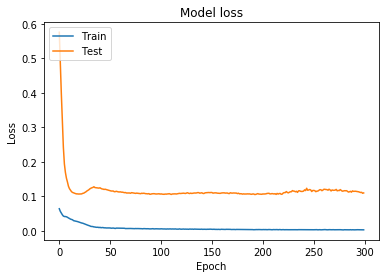

In [307]:
plotLoss(history)  # IMP!

In [308]:
# x_test_t 

In [309]:
def calcError(model, x_test_t, y_test_t, y_pred_org, y_test_t_org):
    y_pred = model.predict(createDataset(x_test_t, batchSize), batch_size=batchSize)
    y_pred = y_pred.flatten()
    y_test_t = createDataset(y_test_t, batchSize)
    error = mean_squared_error(y_test_t, y_pred)
    return ("Error is", error, y_pred.shape, y_test_t.shape)

    print(y_pred[0:15])
    print(y_test_t[0:15])
    y_pred_org = (y_pred * min_max_scaler.data_range_[3]) + min_max_scaler.data_min_[3] # min_max_scaler.inverse_transform(y_pred)
    y_test_t_org = (y_test_t * min_max_scaler.data_range_[3]) + min_max_scaler.data_min_[3] # min_max_scaler.inverse_transform(y_test_t)
    print(y_pred_org[0:15])
    print(y_test_t_org[0:15])

In [310]:
calcError(model, x_test_t, y_test_t, y_pred_org, y_test_t_org)  # IMP!

('Error is', 0.0032825963042175483, (20,), (20,))

In [311]:
# y_pred

In [312]:
from matplotlib import pyplot as plt

def plotPrediction(y_pred_org, y_test_t_org):
    stime = time.time()
    
    plt.figure()
    plt.plot(y_pred_org)
    plt.plot(y_test_t_org)
    plt.title('Prediction vs Real Stock Price')
    plt.ylabel('Price')
    plt.xlabel('Days')
    plt.legend(['Prediction', 'Real'], loc='upper left')
    plt.show()
    print("program completed ", time.time() - stime)

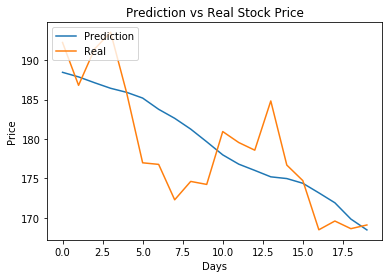

program completed  0.146881103515625


In [313]:
plotPrediction(y_pred_org, y_test_t_org) # IMP!

In [314]:
# x_test_t

In [315]:
# # try with real testing data


# y_pred = lstm_model.predict(createDataset(x_test_t, batchSize), batch_size=batchSize)
# y_pred = y_pred.flatten()
# y_test_t = createDataset(y_test_t, batchSize)
# error = mean_squared_error(y_test_t, y_pred)
# print("Error is", error, y_pred.shape, y_test_t.shape)
# print(y_pred[0:15])
# print(y_test_t[0:15])
# y_pred_org = (y_pred * min_max_scaler.data_range_[3]) + min_max_scaler.data_min_[3] # min_max_scaler.inverse_transform(y_pred)
# y_test_t_org = (y_test_t * min_max_scaler.data_range_[3]) + min_max_scaler.data_min_[3] # min_max_scaler.inverse_transform(y_test_t)
# print(y_pred_org[0:15])
# print(y_test_t_org[0:15])

In [316]:
# is_update_model = True
# if model is None or is_update_model:
#     from keras import backend as K
#     print("Building model...")
#     print("checking if GPU available", K.tensorflow_backend._get_available_gpus())
#     model = create_model()
    
#     es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,
#                        patience=40, min_delta=0.0001)
    
#     mcp = ModelCheckpoint(os.path.join(OUTPUT_PATH,
#                           "best_model.h5"), monitor='val_loss', verbose=1,
#                           save_best_only=True, save_weights_only=False, mode='min', period=1)

#     # Not used here. But leaving it here as a reminder for future
#     r_lr_plat = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=30, 
#                                   verbose=0, mode='auto', min_delta=0.0001, cooldown=0, min_lr=0)
    
#     csv_logger = CSVLogger(os.path.join(OUTPUT_PATH, 'training_log_' + time.ctime().replace(" ","_") + '.log'), append=True)
    
#     history = model.fit(x_t, y_t, epochs=params["epochs"], verbose=2, batch_size=batchSize,
#                         shuffle=False, validation_data=(createDataset(x_val, batchSize),
#                         createDataset(y_val, batchSize)), callbacks=[es, mcp, csv_logger])
    
#     print("saving model...")
#     pickle.dump(model, open("lstm_model", "wb"))

# # model.evaluate(x_test_t, y_test_t, batch_size=batchSize
# y_pred = model.predict(createDataset(x_test_t, batchSize), batch_size=batchSize)
# y_pred = y_pred.flatten()
# y_test_t = createDataset(y_test_t, batchSize)
# error = mean_squared_error(y_test_t, y_pred)
# print("Error is", error, y_pred.shape, y_test_t.shape)
# print(y_pred[0:15])
# print(y_test_t[0:15])

# # convert the predicted value to range of real data
# y_pred_org = (y_pred * min_max_scaler.data_range_[3]) + min_max_scaler.data_min_[3]
# # min_max_scaler.inverse_transform(y_pred)
# y_test_t_org = (y_test_t * min_max_scaler.data_range_[3]) + min_max_scaler.data_min_[3]
# # min_max_scaler.inverse_transform(y_test_t)
# print(y_pred_org[0:15])
# print(y_test_t_org[0:15])

# # Visualize the training data
# from matplotlib import pyplot as plt
# plt.figure()
# plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])
# plt.title('Model loss')
# plt.ylabel('Loss')
# plt.xlabel('Epoch')
# plt.legend(['Train', 'Test'], loc='upper left')
# #plt.show()
# plt.savefig(os.path.join(OUTPUT_PATH, 'train_vis_BS_'+str(batchSize)+"_"+time.ctime()+'.png'))

# # load the saved best model from above
# saved_model = load_model(os.path.join(OUTPUT_PATH, 'best_model.h5')) # , "lstm_best_7-3-19_12AM",
# print(saved_model)

# y_pred = saved_model.predict(createDataset(x_test_t, batchSize), batch_size=batchSize)
# y_pred = y_pred.flatten()
# y_test_t = createDataset(y_test_t, batchSize)
# error = mean_squared_error(y_test_t, y_pred)
# print("Error is", error, y_pred.shape, y_test_t.shape)
# print(y_pred[0:15])
# print(y_test_t[0:15])
# y_pred_org = (y_pred * min_max_scaler.data_range_[3]) + min_max_scaler.data_min_[3] # min_max_scaler.inverse_transform(y_pred)
# y_test_t_org = (y_test_t * min_max_scaler.data_range_[3]) + min_max_scaler.data_min_[3] # min_max_scaler.inverse_transform(y_test_t)
# print(y_pred_org[0:15])
# print(y_test_t_org[0:15])

# # Visualize the prediction
# from matplotlib import pyplot as plt
# plt.figure()
# plt.plot(y_pred_org)
# plt.plot(y_test_t_org)
# plt.title('Prediction vs Real Stock Price')
# plt.ylabel('Price')
# plt.xlabel('Days')
# plt.legend(['Prediction', 'Real'], loc='upper left')
# #plt.show()
# plt.savefig(os.path.join(OUTPUT_PATH, 'pred_vs_real_BS'+str(batchSize)+"_"+time.ctime()+'.png'))
# print_time("program completed ", stime)